# Convolution Embedding

<img src="./../CvT-SimplifiedEmbedding.drawio.png?raw=1" alt="CvT-Modell mit Convolutional Embedding" title="CvT-Modell mit Convolutional Embedding" height="400" />

Dimensions sind ohne Batch-Size.

## Input-Dimensions

**Dimensions:** $H_0 = 64px, \quad W_0 = 64px, \quad C_0 = 3$ \
**Output-Shape:** `(3, 64, 64)`

## Conv2d

Berechnung Output-Dimensions:

$ \text{kernel size}\ k = 7, \quad \text{stride}\ s = 4, \quad \text{padding}\ p = 3 $ \
$ H_i = \frac{H_{i-1} + 2p - k}{s}\ + 1, \quad W_i = \frac{W_{i-1} + 2p - k}{s}\ + 1 $

**Output-Dimensions:** $H_1 = 16px, \quad W_1 = 16px, \quad C_1 = 64$ \
**Output-Shape:** `(64, 16, 16)`

## Flatten

**Output-Dimensions:** $H_1 W_1 \times C_1 = 16*16 \times 64$ \
**Output-Shape:** `(256, 64)`

## Multi-Head Attention

Berechnung der Query-, Key- und Value-Matrizen:

$X \in \mathbb{R}^{H_1 W_1 \times C_1}$ \
$d_k$ ist die Dimension der Value-, Query- und Key-Vektoren \
$W^Q, W^K, W^V \in \mathbb{R}^{C_1 \times d_k}$ \
$Q = XW^Q, \quad K = XW^K, \quad V = XW^V$

$d_k = 64$ \
$Q, K, V \in \mathbb{R}^{256 \times 64}$

**Output-Dimensions:** $256 \times 64$ \
**Output-Shape:** `(256, 64)`

## MLP

Expansion factor: $e = 4$

1. **Step:** Linear ➔ GELU ➔ Dropout
   
   **Output-Dimensions:** $256 \times 64 \times 4 = 256 \times 256$ \
   **Output-Shape:** `(256, 256)`

2. **Step:** Linear ➔ Dropout

    **Output-Dimensions:** $256 \times 256 \times 64 = 256 \times 64$ \
    **Output-Shape:** `(256, 64)`


# Imports

In [1]:
%pip install pytorch-lightning
%pip install torch torchvision
%pip install lightning
%pip install einops
%pip install dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 16.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 55.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 17.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import torch
from einops import rearrange
import torch.nn as nn

IS_PAPERSPACE = os.getcwd().startswith('/notebooks')
dir_env = os.path.join(os.getcwd(), '.env') if IS_PAPERSPACE else os.path.join(os.getcwd(), '..', '.env')
_ = load_dotenv(dotenv_path=dir_env)

# Modell

In [3]:
class EmbeddingBlock(nn.Module):
    def __init__(self,
                 in_channels=3,
                 embed_dim=64,
                 patch_size=7,
                 stride=4,
                 padding=3,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        self.proj = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size,
            stride=stride,
            padding=padding
        )
        self.norm = norm_layer(embed_dim)

    def forward(self, x):
        x = self.proj(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.norm(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self,
                 embed_dim=64,
                 num_heads=1,
                 mlp_ratio=4.0,
                 drop=0.1,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop, batch_first=True)

        self.norm2 = norm_layer(embed_dim)
        hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(drop)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x
    
class CvTSimplifiedEmbedding(nn.Module):
    def __init__(self,
                 in_channels=3,
                 num_classes=200,
                 embed_dim=64,
                 depth=2):
        super().__init__()

        self.num_classes = num_classes

        self.embedding = EmbeddingBlock(
            in_channels=in_channels,
            embed_dim=embed_dim,
            stride=4,
            padding=3,
            norm_layer=nn.LayerNorm
        )

        self.transformer_blocks = nn.Sequential(*[
            TransformerBlock() for _ in range(depth)
        ])

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(1),
            nn.Linear(embed_dim, num_classes)
        )


    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_blocks(x)
        x = x.permute(0, 2, 1)
        x = self.head(x)
        return x

## Testing

In [4]:
input = torch.randn(2, 3, 64, 64)
excepted_output_shape = (2, 256, 64)

embedding_block = EmbeddingBlock()
transformer_block = TransformerBlock()

output = embedding_block(input)
output = transformer_block(output)

assert output.shape == excepted_output_shape, f"Expected shape {excepted_output_shape}, but got {output.shape}"
print("Output shape is as expected:", output.shape)

model = CvTSimplifiedEmbedding()
dummy_input = torch.randn(8, 3, 64, 64)
output = model(dummy_input)

assert output.shape == (8, 200), f"Expected output shape (8, 200), but got {output.shape}"
print("Model output shape is as expected:", output.shape)

Output shape is as expected: torch.Size([2, 256, 64])
Model output shape is as expected: torch.Size([8, 200])


# Dataset

In [21]:
from processData import prepare_data_and_get_loaders

train_loader, val_loader, test_loader = prepare_data_and_get_loaders("../data/tiny-imagenet-200.zip", "../data/tiny-imagenet-200")

Data already extracted.


### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54300606..1.8317859].


0


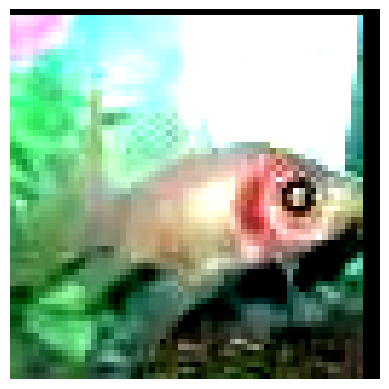

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54300606..1.7183223].


0


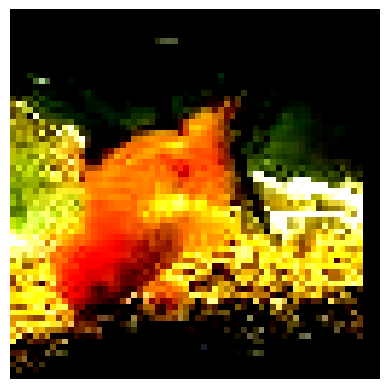

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54300606..1.8317859].


0


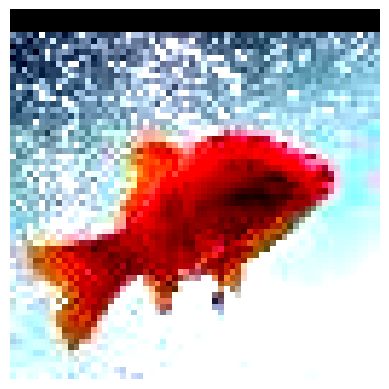

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54300606..1.8317859].


0


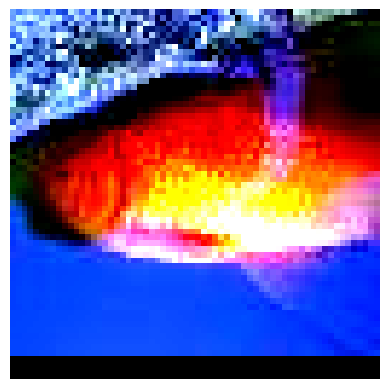

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54300606..1.8317859].


2


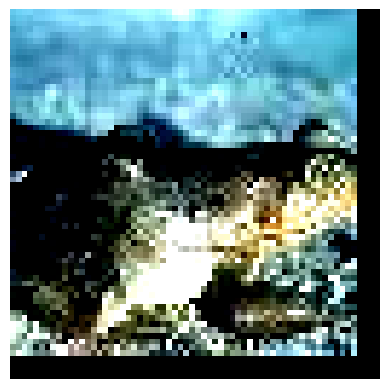

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54300606..1.7537708].


2


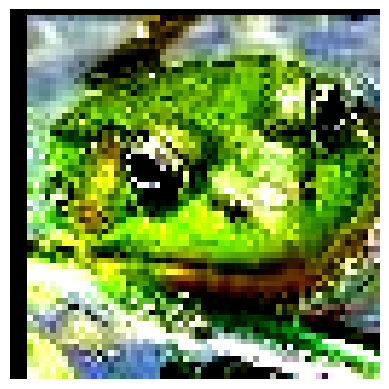

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54300606..1.476383].


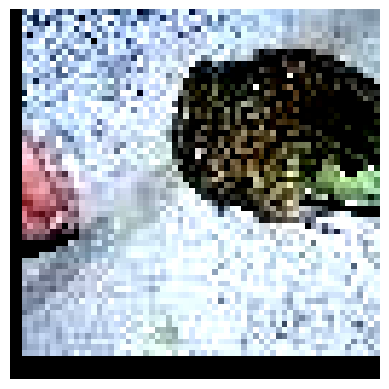

2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54300606..1.8317859].


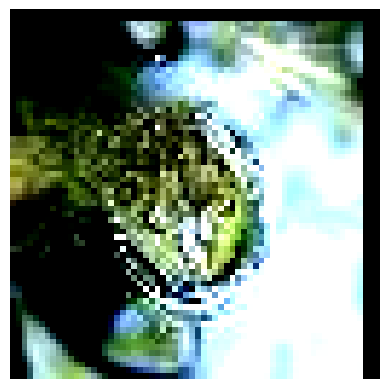

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

for i in range(4):
    image, label = val_loader.dataset[i]
    print(label)
    imshow(image)

for i in range(1000, 1004):
    image, label = val_loader.dataset[i]
    print(label)
    imshow(image)

# Training

In [7]:
from models.trainModel import train_test_model

train_test_model(model, train_loader, val_loader, test_loader)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: seya-schmassmann-fhnw (wods). Use `wandb login --relogin` to force relogin


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | CvTSimplifiedEmbedding | 122 K  | train
1 | criterion | CrossEntropyLoss       | 0      | train
2 | train_acc | MulticlassAccuracy     | 0      | train
3 | val_acc   | MulticlassAccuracy     | 0      | train
4 | test_acc  | MulticlassAccuracy     | 0      | train
-------------------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.490     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.21549999713897705
        test_loss            3.514784812927246
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
test_acc,▁
test_loss,▁
train_acc,▁▃▄▅▅▆▆▆▇▇▇▇▇███████
train_loss,██▇▆▅▆▄▄▅▃▅▃▅▃▄▃▂▃▂▂▃▃▁▂▄▃▂▁▃▂▂▁▄▂▃▃▂▁▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▃▄▅▅▅▆▆▇▇▇▇▇███████
val_loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,20
test_acc,0.2155
test_loss,3.51478
